In [1]:
!pip freeze

alembic==1.4.1
appdirs==1.4.3
asn1crypto==1.3.0
astroid==2.3.3
attrs==19.3.0
autopep8==1.5
backcall==0.1.0
bleach==3.1.0
bokeh==2.0.1
cached-property==1.5.1
catboost==0.22
certifi==2019.11.28
cffi==1.14.0
chardet==3.0.4
click==7.1.1
cloudpickle==1.3.0
conda==4.8.3
conda-package-handling==1.6.0
configparser==5.0.0
cryptography==2.8
cycler==0.10.0
dask==2.13.0
databricks-cli==0.9.1
decorator==4.4.2
defusedxml==0.6.0
distributed==2.13.0
docker==4.2.0
entrypoints==0.3
Flask==1.1.1
fsspec==0.7.1
gitdb==4.0.2
GitPython==3.1.0
gorilla==0.3.0
graphviz==0.13.2
gunicorn==20.0.4
HeapDict==1.0.1
idna==2.9
imbalanced-learn==0.6.2
importlib-metadata==1.5.0
ipykernel==5.1.4
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
isodate==0.6.0
isort==4.3.21
itsdangerous==1.1.0
jedi==0.16.0
Jinja2==2.11.1
joblib==0.14.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.0.0
jupyter-console==6.1.0
jupyter-core==4.6.1
kiwisolver==1.1.0
lazy-object-proxy==1.4.3
llvmlite==0.31.0
locket==0.2.0
lxml==4.5.

In [257]:
%autosave 10
import sys
import pandas as pd
from io import BytesIO
import logging
import datetime as dt
import requests

logger = logging.getLogger(__name__)


def execute_query(query,
                  token='',
                  cluster='hahn',
                  alias="*ch_public",
                  timeout=600):
    '''Query to ClickHouse. Uses native ClickHouse Rest API'''
    logger.info("Executing query: %s", query)
    proxy = "http://{}.yt.yandex.net".format(cluster)
    session = requests.Session()
    url = "{proxy}/query?database={alias}&password={token}".format(proxy=proxy,
                                                                   alias=alias, token=token)
    resp = session.post(url, data=query, timeout=timeout)
    if resp.status_code != 200:
        logger.error("Response status: %s", resp.status_code)
        logger.error("Response headers: %s", resp.headers)
        logger.error("Response content: %s", resp.content)
    resp.raise_for_status()
    rows = resp.content.strip()
    logger.info("Time spent: %s seconds, rows returned: %s",
                resp.elapsed.total_seconds(), len(rows))
    return rows

Autosaving every 10 seconds


In [4]:
from os.path import expanduser, join



def get_token(token_file_path='.yt/api_token', home_dir='~'):
    '''Reads token from file'''
    home = expanduser(home_dir)
    with open(join(home, token_file_path), 'r') as tokenfile:
        token = tokenfile.read()
    return token


In [5]:
token = get_token()

In [48]:
tickets_per_month = execute_query('''
    SELECT cloud_id, toStartOfMonth(created_at) as month, pay_type, count(st_key) as n_tickets
    FROM
        (SELECT DISTINCT cloud_id, toDateTime(created_at) created_at, st_key, pay_type
        FROM "//home/cloud/billing/exported-support-tables/tickets_prod" 
        INNER JOIN 
            (SELECT task as st_key, pay_type
            FROM "//home/cloud_analytics/import/tracker/support_tasks") sup_type 
            USING st_key) 
    WHERE isNotNull(cloud_id)
    GROUP BY cloud_id, month, pay_type
 FORMAT CSVWithNames
''', token)

In [258]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
                 
tickets_per_month_df = pd.read_csv(BytesIO(tickets_per_month), parse_dates=['month'], date_parser=dateparse,
                                   na_values='\\N')

In [259]:
tickets_per_month_df

,cloud_id,month,pay_type,n_tickets
0,b1gu54vmd2h60f1ai5c7,2019-10-01,free,1
1,b1gqt7hkqj78gfke93tu,2019-12-01,standard,6
2,b1g246himpeh2sesicl9,2019-10-01,free,1
3,b1gsv7gsucr81k3as5ad,2019-11-01,free,1
4,b1ggmo5nddutckbaduu9,2020-03-01,free,1
...,...,...,...,...
7794,b1gg3fa8qnenbf4ilj79,2019-12-01,standard,1
7795,b1gp2h53hmj4e2v5k8ud,2019-07-01,free,1
7796,b1gsql6infhpvh2ncjib,2019-10-01,free,2
7797,b1gls9f5a09a31fdnih8,2019-06-01,free,1


In [260]:
tickets_per_month_df.dtypes

cloud_id             object
month        datetime64[ns]
pay_type             object
n_tickets             int64
dtype: object

In [52]:
tickets_per_month_df = tickets_per_month_df.dropna()

In [ ]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
                 
tickets_per_month_df = pd.read_csv(BytesIO(tickets_per_month), parse_dates=['month'], date_parser=dateparse,
                                   na_values='\\N')

In [53]:
from matplotlib import pyplot as plt

In [61]:
tickets_per_month_df.loc[tickets_per_month_df['n_tickets'].idxmax(), :]

cloud_id     b1g25gm5d5n5v66qbhg4
month                  2019-10-01
pay_type                  premium
n_tickets                      31
Name: 5201, dtype: object

In [63]:
tickets_per_month_df.groupby('pay_type')['n_tickets'].describe()

,count,mean,std,min,25%,50%,75%,max
pay_type,,,,,,,,
business,498.0,2.477912,2.540718,1.0,1.00,1.0,3.0,18.0
free,6899.0,1.450645,1.168219,1.0,1.00,1.0,1.0,25.0
premium,70.0,5.542857,6.025756,1.0,1.25,4.0,7.0,31.0
standard,296.0,1.736486,1.427865,1.0,1.00,1.0,2.0,12.0


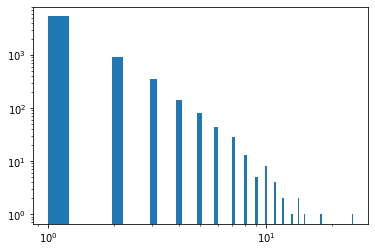

In [69]:
plt.hist(tickets_per_month_df[tickets_per_month_df['pay_type'] == 'free']['n_tickets'], bins=100);
plt.yscale('log')
plt.xscale('log')

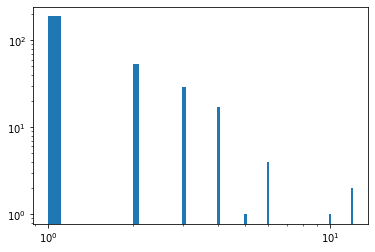

In [70]:
plt.hist(tickets_per_month_df[tickets_per_month_df['pay_type'] == 'standard']['n_tickets'], bins=100);
plt.yscale('log')
plt.xscale('log')

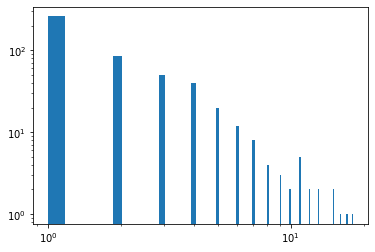

In [71]:
plt.hist(tickets_per_month_df[tickets_per_month_df['pay_type'] == 'business']['n_tickets'], bins=100);
plt.yscale('log')
plt.xscale('log')

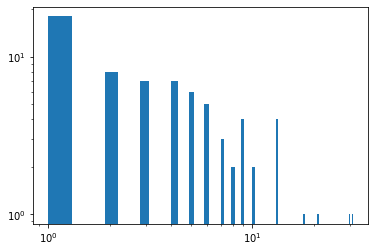

In [77]:
plt.hist(tickets_per_month_df[tickets_per_month_df['pay_type'] == 'premium']['n_tickets'], bins=100);
plt.yscale('log')
plt.xscale('log')

In [57]:
tickets_per_month_df[tickets_per_month_df['pay_type'] == 'free']['n_tickets'].describe()

count    6899.000000
mean        1.450645
std         1.168219
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        25.000000
Name: n_tickets, dtype: float64

In [60]:
tickets_per_month_df[tickets_per_month_df['pay_type'] == 'standard']['n_tickets'].describe()

count    296.000000
mean       1.736486
std        1.427865
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: n_tickets, dtype: float64

In [79]:
# !pip install powerlaw==1.4.6

In [80]:
import powerlaw

In [97]:
free_tickets = tickets_per_month_df[tickets_per_month_df['pay_type'] == 'free']['n_tickets'].values
standard_tickets = tickets_per_month_df[tickets_per_month_df['pay_type'] == 'standard']['n_tickets'].values

In [94]:
free_pl = powerlaw.Fit(free_tickets, discrete=True)

Calculating best minimal value for power law fit
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [92]:
free_pl.alpha

3.9846384389523695

Calculating best minimal value for power law fit
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-0.29691652592352247, 0.6526086275818807)

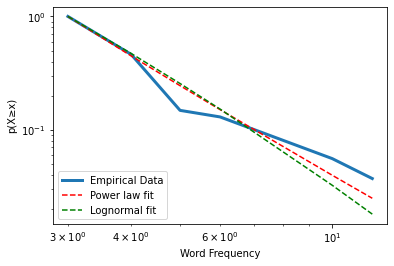

In [98]:
fit = powerlaw.Fit(standard_tickets, discrete=True)
####
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Word Frequency")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)
fit.distribution_compare('power_law', 'lognormal')




Calculating best minimal value for power law fit
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/bakuteev/miniconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-1.30290904170695, 0.3479628804118017)

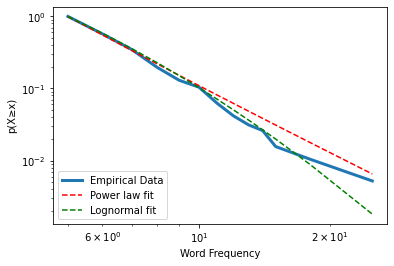

In [142]:
fit = powerlaw.Fit(free_tickets, discrete=True)
####
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Word Frequency")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)
fit.distribution_compare('power_law', 'lognormal')



Loglikelihood ratio of the two distributions’ fit to the data. If greater than 0, the first distribution is preferred. If less than 0, the second distribution is preferred.

In [144]:
import numpy as np
from scipy.stats import geom, lognorm
from scipy.stats import powerlaw as pl

In [143]:
fit.alpha, pl.pdf()

3.9846384389523695

In [151]:
pl.fit(free_tickets)

(0.19886210449827418, 0.9999999999999999, 26.93157690945605)

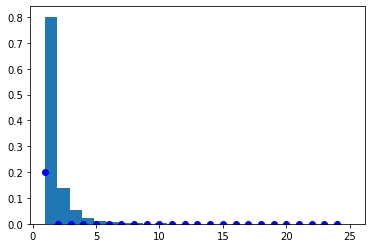

In [158]:
plt.hist(free_tickets, bins=25, density=True);
x = np.arange(1, np.max(free_tickets))
plt.plot(x, pl.pdf(x, 0.2), 'bo')
# plt.yscale('log')
# plt.xscale('log')

In [141]:
np.mean(np.log(free_tickets))

0.226561395887503

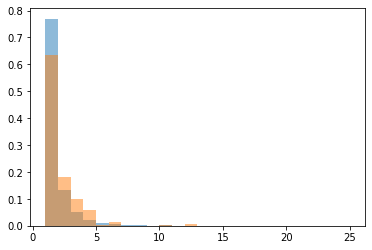

In [179]:
plt.hist(free_tickets, bins=np.arange(1,26), density=1, alpha=0.5);
plt.hist(standard_tickets, bins=np.arange(1,26), density=1, alpha=0.5);

In [182]:
!pip install statsmodels==0.11.1

In [183]:
from statsmodels.distributions.empirical_distribution import ECDF

In [186]:
free_ecdf = ECDF(free_tickets)

In [187]:
standard_ecdf = ECDF(standard_tickets)

In [188]:
np.percentile(free_tickets, 95)

3.0

In [189]:
np.percentile(standard_tickets, 95)

4.0

In [227]:
n_people_free = 100
n_people_standard = 100
n_sim = 5000
free_tickets_total = np.random.choice(free_tickets, (n_people_free, n_sim)).sum(axis=0)
standard_tickets_total = np.random.choice(standard_tickets, (n_people_standard, n_sim)).sum(axis=0)



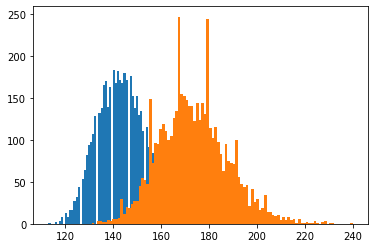

In [228]:
plt.hist(free_tickets_total, bins=100);
plt.hist(standard_tickets_total, bins=100);

In [229]:
from scipy import stats

In [230]:
stats.kstest(free_tickets_total, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [231]:
stats.kstest(standard_tickets_total, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [232]:
stats.shapiro(free_tickets_total)

(0.9838692545890808, 1.8521759856992763e-23)

In [233]:
stats.shapiro(standard_tickets)

(0.5534000992774963, 7.971484128833034e-27)

Not normal

In [234]:
np.percentile(free_tickets_total,5), np.percentile(free_tickets_total,95)

(128.0, 165.0)

In [235]:
np.percentile(standard_tickets_total,5), np.percentile(standard_tickets_total,95)

(152.0, 198.0)

In [238]:
x=4751/2

In [240]:
1.74*x - 1.45*x

688.895

# By BA pay type

In [264]:
%%time
tickets = execute_query('''
    SELECT DISTINCT cloud_id, toDateTime(created_at) created_at, st_key, pay_type
        FROM "//home/cloud/billing/exported-support-tables/tickets_prod" 
        INNER JOIN 
            (SELECT task as st_key, pay_type
            FROM "//home/cloud_analytics/import/tracker/support_tasks") sup_type 
            USING st_key
    WHERE isNotNull(cloud_id)
    FORMAT CSVWithNames
    ''',
    token)

CPU times: user 14.1 ms, sys: 2.95 ms, total: 17 ms
Wall time: 1.22 s


In [298]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                 
tickets_df = pd.read_csv(BytesIO(tickets), parse_dates=['created_at'], date_parser=dateparse,
                                   na_values='\\N')

In [299]:
tickets_df.dtypes

cloud_id              object
created_at    datetime64[ns]
st_key                object
pay_type              object
dtype: object

In [300]:
"b1gsvdflv8usju6fuqfd"	"2019-09-04 11:27:38"	"CLOUDSUPPORT-11459"	"free"

'b1gsvdflv8usju6fuqfd2019-09-04 11:27:38CLOUDSUPPORT-11459free'

In [301]:
tickets_df

,cloud_id,created_at,st_key,pay_type
0,b1gpe2fbikrru4nqd53f,2019-11-29 14:26:12,CLOUDSUPPORT-18607,business
1,b1gv43ava9e39qdbaioq,2019-11-29 14:34:26,CLOUDSUPPORT-18610,free
2,b1ghdrl6kg1ipin8fpqr,2019-11-29 14:36:42,CLOUDSUPPORT-18613,free
3,NaN,2019-11-29 14:38:00,CLOUDSUPPORT-18616,free
4,b1g8dgq48lkl79fb0c7l,2019-11-29 14:54:29,CLOUDSUPPORT-18620,free
...,...,...,...,...
14655,b1g37atlou5q6ctfsn72,2020-04-19 17:48:14,CLOUDSUPPORT-31212,free
14656,b1g565pim0bs5ni6vup0,2020-04-19 18:12:11,CLOUDSUPPORT-31213,business
14657,b1g7069i80lrk8d5423c,2020-04-19 19:08:19,CLOUDSUPPORT-31216,free
14658,b1gbvis0h2236f1p80i7,2020-04-19 22:44:16,CLOUDSUPPORT-31222,standard


In [302]:
first_paid_events = execute_query('''
    SELECT cloud_id, event_time as first_paid
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    WHERE event = 'first_paid_consumption' AND ba_usage_status != 'service'
    FORMAT CSVWithNames
    '''
, token)
first_paid_events_df = pd.read_csv(BytesIO(first_paid_events), parse_dates=['first_paid'], date_parser=dateparse,
                                   na_values='\\N')

In [303]:
tickets_df = first_paid_events_df.merge(tickets_df, on='cloud_id', how='right')

In [304]:
tickets_df

,cloud_id,first_paid,created_at,st_key,pay_type
0,b1g619qh4dd8g4sjnpcq,2018-12-04 02:59:59,2020-02-04 10:50:00,CLOUDSUPPORT-25486,free
1,b1gkmioj7f7qjh7cpd52,2019-08-26 11:59:59,2019-09-18 10:30:31,CLOUDSUPPORT-12179,free
2,b1gtf4b87ghlaff5jels,2019-04-02 03:59:59,2019-09-25 09:50:53,CLOUDSUPPORT-12535,free
3,b1g3u89ll0ud5p1r963b,2019-09-08 14:59:59,2019-08-13 18:28:16,CLOUDSUPPORT-10298,free
4,b1g3u89ll0ud5p1r963b,2019-09-08 14:59:59,2019-08-15 10:06:26,CLOUDSUPPORT-10391,free
...,...,...,...,...,...
60657,b1gfraho55iuckl30qtr,NaT,2020-04-19 13:31:23,CLOUDSUPPORT-31200,free
60658,b1gmc53ln4m5q1gbr6e6,NaT,2020-04-19 14:47:43,CLOUDSUPPORT-31204,free
60659,b1g7p40tqjl0pntr227h,NaT,2020-04-19 14:57:06,CLOUDSUPPORT-31205,free
60660,b1ggsdbf44rrtijpdhlm,NaT,2020-04-19 15:53:38,CLOUDSUPPORT-31209,free


In [305]:
tickets_df.first_paid.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
60657     True
60658     True
60659     True
60660     True
60661     True
Name: first_paid, Length: 60662, dtype: bool

In [306]:
trial_mask = (tickets_df.first_paid.isna() | (tickets_df.created_at < tickets_df.first_paid))

In [307]:
tickets_df.first_paid = trial_mask.map({True: 'trial', False: 'paid'})

In [308]:
tickets_df['month'] = tickets_df.created_at.dt.to_period('M')

In [313]:
tickets_count_df = tickets_df.groupby(['cloud_id', 'month', 'pay_type', 'first_paid'])['st_key'].count()

In [315]:
tickets_count_df = tickets_count_df.reset_index()
tickets_count_df

,cloud_id,month,pay_type,first_paid,st_key
0,b1g00ciqp9cntchrso48,2019-08,free,trial,1
1,b1g00cmf9fhtf3us1mds,2020-01,free,paid,1
2,b1g00e9vae2mgna79e56,2019-11,free,trial,1
3,b1g00pbfi9rq6qpv31lp,2019-10,free,trial,1
4,b1g00s5t8mibtaqcal9u,2020-03,free,trial,1
...,...,...,...,...,...
8522,b1gvv8ssf3gu5ssoj0fr,2020-01,free,paid,2
8523,b1gvv8ssf3gu5ssoj0fr,2020-02,free,paid,2
8524,b1gvvveok0jto41cd95h,2020-01,free,paid,5
8525,b1gvvveok0jto41cd95h,2020-01,free,trial,1


In [336]:
tickets_mean = tickets_count_df.groupby(['first_paid'])['st_key'].agg(['mean', 'sum']).copy()

In [337]:
print(tickets_mean.reset_index().to_markdown())

|    | first_paid   |    mean |   sum |
|---:|:-------------|--------:|------:|
|  0 | paid         | 1.79564 |  6836 |
|  1 | trial        | 1.50763 |  7116 |


In [322]:
tickets_count_df.groupby(['pay_type', 'first_paid'])['cloud_id'].nunique()

pay_type  first_paid
business  paid           126
          trial           71
free      paid          1910
          trial         3864
premium   paid            10
          trial           12
standard  paid           127
          trial           86
Name: cloud_id, dtype: int64

In [321]:
tickets_count_df.groupby(['first_paid', 'pay_type'])['cloud_id'].nunique()

first_paid  pay_type
paid        business     126
            free        1910
            premium       10
            standard     127
trial       business      71
            free        3864
            premium       12
            standard      86
Name: cloud_id, dtype: int64

In [319]:
tickets_count_df.groupby(['first_paid'])['st_key'].describe()

,count,mean,std,min,25%,50%,75%,max
first_paid,,,,,,,,
paid,3807.0,1.795640,1.965614,1.0,1.0,1.0,2.0,45.0
trial,4720.0,1.507627,1.635310,1.0,1.0,1.0,1.0,37.0
